In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from tensorflow.keras.losses import binary_crossentropy
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-02-28 12:54:40.468625: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 12:54:40.468789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 12:54:40.640249: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Set TensorFlow to only use the first GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print("No GPUs found!")

No GPUs found!


In [12]:
input_path = '/kaggle/input/airbus-ship-detection'
train_dir_path = os.path.join(input_path, 'train_v2/')
test_dir_path = os.path.join(input_path, 'test_v2/')

In [13]:
train_masks = pd.read_csv(os.path.join(input_path,'train_ship_segmentations_v2.csv'))
train_masks

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN


In [14]:
train_masks.shape

(231723, 2)

We have 231723 images

In [15]:
train_masks.isna().sum()

ImageId               0
EncodedPixels    150000
dtype: int64

We can see, that there is no NaN or empty values in ImageIds, and we have 150000 empty maskencdoing. It means, that our data contains 150000 images with no ships in it, and 81723 with ships in images

In [16]:
train_masks['ImageId'].value_counts()

ImageId
e6fd0c12e.jpg    15
2053a78bd.jpg    15
d3c47b3d3.jpg    15
4de149bd9.jpg    15
c8e722430.jpg    15
                 ..
591ab2331.jpg     1
591af2fb2.jpg     1
591afc23d.jpg     1
591b2dd30.jpg     1
ffffe97f3.jpg     1
Name: count, Length: 192556, dtype: int64

In [17]:
train_masks['ImageId'].value_counts().shape[0]

192556

We can see, that we have some duplicates in ImageIds, and have 192556 unique images.

In [18]:
train_masks[train_masks['ImageId'] == 'e6fd0c12e.jpg']

,ImageId,EncodedPixels
208972,e6fd0c12e.jpg,535742 2 536508 4 537274 7 538040 9 538807 8 5...
208973,e6fd0c12e.jpg,518107 1 518874 3 519642 2 520409 1 521176 1
208974,e6fd0c12e.jpg,577030 1 577798 3 578565 6 579333 8 580100 10 ...
208975,e6fd0c12e.jpg,578764 3 579532 3 580299 3 581067 3 581835 3 5...
208976,e6fd0c12e.jpg,516568 2 517335 2 521172 1
208977,e6fd0c12e.jpg,577223 1 577990 3 578758 1 579526 1 580294 1 5...
208978,e6fd0c12e.jpg,519644 1 520411 2 521177 3 521944 3 522711 3 5...
208979,e6fd0c12e.jpg,539584 1 540350 3 541116 3 541882 2
208980,e6fd0c12e.jpg,521181 2 521948 3 522714 4 523481 3 524250 1
208981,e6fd0c12e.jpg,575684 3 576452 3 577220 2 577987 3 578755 2 5...


In [19]:
def show_img(img_id):
    img = Image.open(os.path.join(train_dir_path, img_id))
    plt.imshow(img)

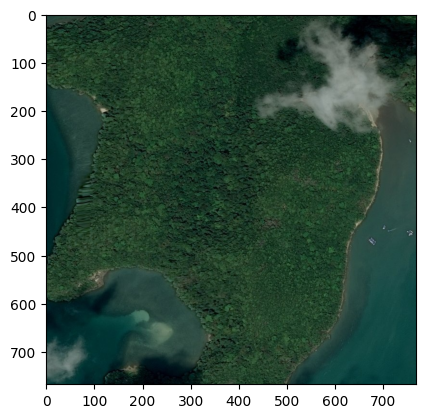

In [20]:
show_img('e6fd0c12e.jpg')

In [21]:
def rle_decode(mask_rle, input_shape=(768,768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    img=np.zeros(input_shape[0]*input_shape[1], dtype=np.float32)
    if not(type(mask_rle) is float):
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1.0
    return img.reshape((input_shape[0],input_shape[1])).T

def show_decode(mask_rle, shape=(768, 768)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    all_masks = np.zeros((768, 768), dtype = np.int16)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += show_decode(mask)
    return np.expand_dims(all_masks, -1)

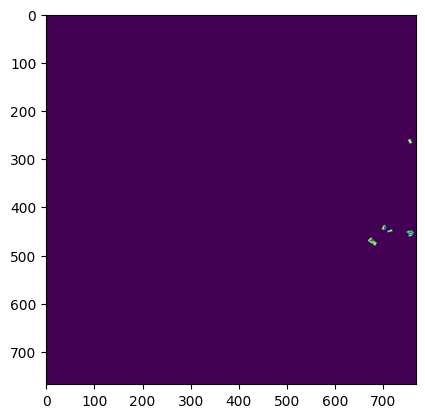

In [22]:
mask_img = masks_as_image(train_masks.query('ImageId=="e6fd0c12e.jpg"')['EncodedPixels'])
plt.imshow(mask_img[:, :, 0])
plt.show()

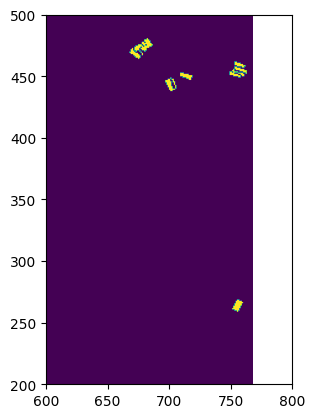

In [23]:
mask_img = masks_as_image(train_masks.query('ImageId=="e6fd0c12e.jpg"')['EncodedPixels'])
plt.imshow(mask_img[:, :, 0])
plt.xlim((600, 800))  
plt.ylim((200, 500))  
plt.show()

We can be now sure, that the duplicates imageids means, that we have more then one ship on image. And amount of ships on image equals amount of duplicates

So now, we can make feature like has ship, and then aggregate it with sum and become amount of ships in each image, and then we can plot distribution of it.

Also i will research image sizes, so we can see, if all images have normal size and there are or not some corupted files or something else, with ploting its distribution 

In [24]:
train_masks['has_ship'] = train_masks['EncodedPixels'].map(lambda x: 1 if x is not np.NaN else 0)
train_masks

,ImageId,EncodedPixels,has_ship
0,00003e153.jpg,NaN,0
1,0001124c7.jpg,NaN,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1
...,...,...,...
231718,fffedbb6b.jpg,NaN,0
231719,ffff2aa57.jpg,NaN,0
231720,ffff6e525.jpg,NaN,0
231721,ffffc50b4.jpg,NaN,0


In [25]:
train_masks_aggregated = train_masks.groupby('ImageId').agg({'has_ship':'sum'}).reset_index()
train_masks_aggregated = train_masks_aggregated.rename(columns={'has_ship': 'ship_amount'})
train_masks_aggregated

,ImageId,ship_amount
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,5
4,0001b1832.jpg,0
...,...,...
192551,fffedbb6b.jpg,0
192552,ffff2aa57.jpg,0
192553,ffff6e525.jpg,0
192554,ffffc50b4.jpg,0


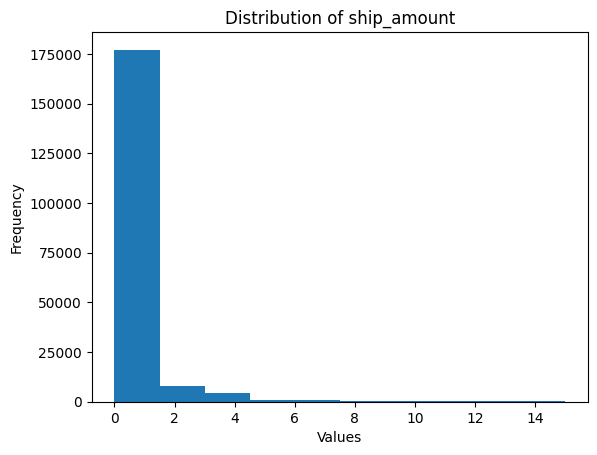

In [26]:
plt.hist(train_masks_aggregated['ship_amount'], bins=10)  
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of ' + 'ship_amount')
plt.show()

Now, we can observe, that most of our images doesn't contain any ships and are empty, so we have some class imbalance, which i need to handle before training process.

Now, let's drop zero values, to see distribution of ships amount on non-empty images

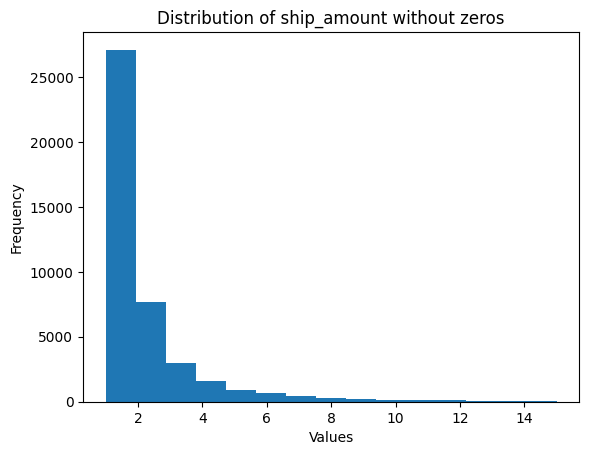

In [27]:
plt.hist(train_masks_aggregated[train_masks_aggregated['ship_amount']>0]['ship_amount'], bins=15)  
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of ship_amount without zeros')
plt.show()

We can observe, that mostly non-empty images have only one or two ships, and small amount, that have more then 5.

Now, let's create one more feature "has_ship", and plot its distribution, so we can see our class imbalance more obvious. 

In [28]:
train_masks_aggregated['has_ship'] = train_masks_aggregated['ship_amount'].map(lambda x: 1 if x > 0 else 0)


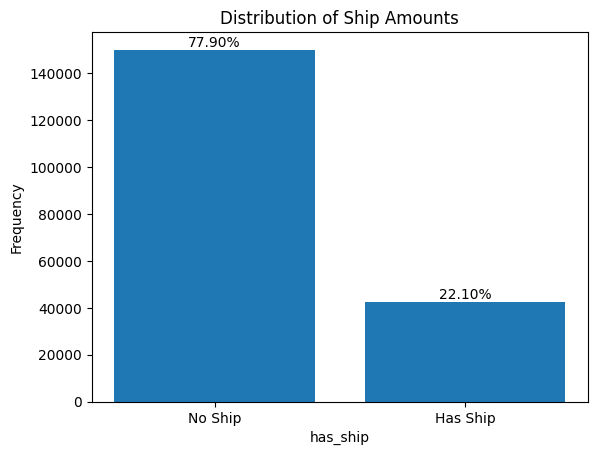

In [29]:
ship_counts = train_masks_aggregated['has_ship'].value_counts()

total_count = ship_counts.sum()

plt.bar(ship_counts.index, ship_counts.values)
plt.xlabel('has_ship')
plt.ylabel('Frequency')
plt.title('Distribution of Ship Amounts')

for i, count in enumerate(ship_counts.values):
    plt.text(i, count, f'{count / total_count * 100:.2f}%', ha='center', va='bottom')

plt.xticks(ship_counts.index, ['No Ship', 'Has Ship'])  
plt.show()

In [30]:
ship_counts

has_ship
0    150000
1     42556
Name: count, dtype: int64

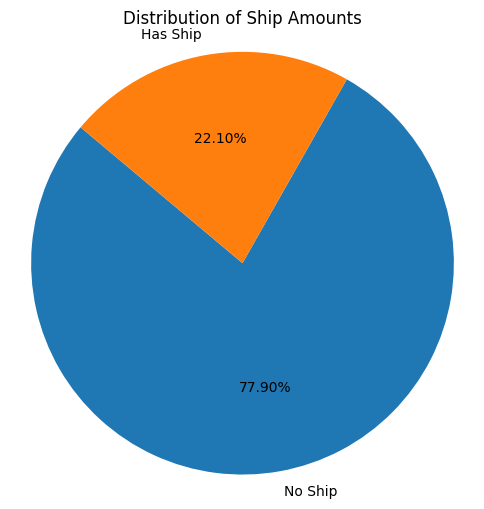

In [31]:
plt.figure(figsize=(6, 6))
plt.pie(ship_counts.values, labels=['No Ship', 'Has Ship'], autopct='%1.2f%%', startangle=140)
plt.title('Distribution of Ship Amounts')
plt.axis('equal')  
plt.show()

Now, we can see, how our classes are imbalanced, and i think for this issue, the best strategy will be undersampling of empty images to amount of non-empty images, so our model can distinguish images with ships and without good.

Now, let's research our image sizes

In [32]:
train_masks_aggregated['file_size_kb'] = train_masks_aggregated['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(train_dir_path, 
                                                                                    c_img_id)).st_size/1024)
train_masks_aggregated

,ImageId,ship_amount,has_ship,file_size_kb
0,00003e153.jpg,0,0,128.944336
1,0001124c7.jpg,0,0,76.059570
2,000155de5.jpg,1,1,147.625977
3,000194a2d.jpg,5,1,75.221680
4,0001b1832.jpg,0,0,95.627930
...,...,...,...,...
192551,fffedbb6b.jpg,0,0,93.918945
192552,ffff2aa57.jpg,0,0,191.762695
192553,ffff6e525.jpg,0,0,108.519531
192554,ffffc50b4.jpg,0,0,98.344727


<Axes: >

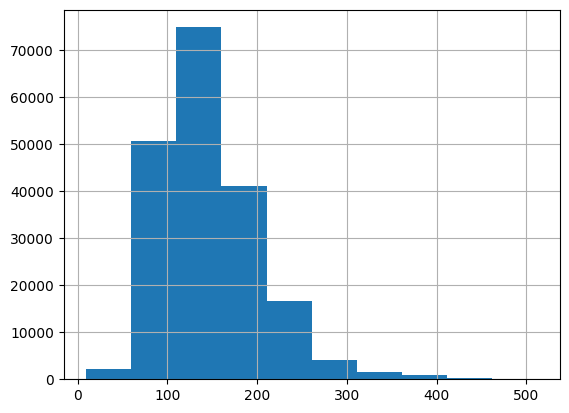

In [33]:
train_masks_aggregated['file_size_kb'].hist()

In [34]:
train_masks_aggregated[train_masks_aggregated['file_size_kb']<70]

,ImageId,ship_amount,has_ship,file_size_kb
15,0005d01c8.jpg,2,1,46.045898
33,000d42241.jpg,1,1,65.922852
84,001bfb70a.jpg,0,0,22.796875
141,002e8a977.jpg,0,0,53.525391
231,004f97cfb.jpg,1,1,67.431641
...,...,...,...,...
192290,ffa01da76.jpg,1,1,46.238281
192345,ffb6af57c.jpg,5,1,57.900391
192415,ffcda19e7.jpg,0,0,60.936523
192433,ffd2a59ec.jpg,0,0,48.944336


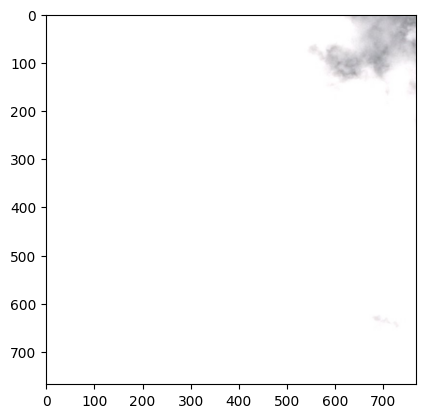

In [35]:
show_img('0080bd6a5.jpg')

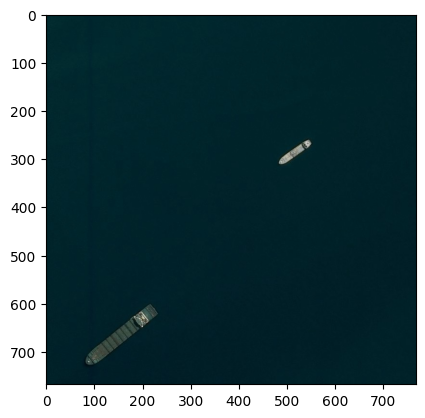

In [36]:
show_img('0005d01c8.jpg')

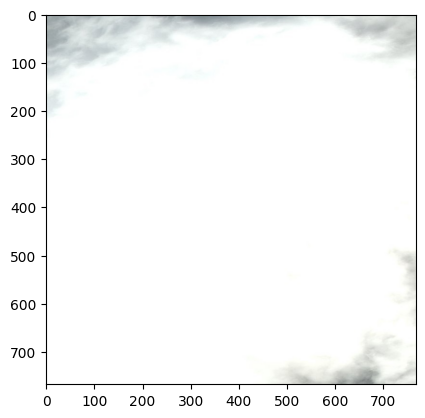

In [37]:
show_img('001bfb70a.jpg')

We can observe, that images, that have under 40 kb size, are corrupted or don't contain useful information, so we need to drop them before training stage  

In [38]:
train_masks_aggregated = train_masks_aggregated[train_masks_aggregated['file_size_kb']>50]

Now let's undersample our data

In [39]:
minority_class = train_masks_aggregated[train_masks_aggregated['has_ship'] == 1]
majority_class = train_masks_aggregated[train_masks_aggregated['has_ship'] == 0]

undersampled_majority_class = resample(majority_class, 
                                      replace=False,  
                                      n_samples=len(minority_class),  
                                      random_state=42)  

undersampled_train_masks = pd.concat([minority_class, undersampled_majority_class])
undersampled_train_masks

,ImageId,ship_amount,has_ship,file_size_kb
2,000155de5.jpg,1,1,147.625977
3,000194a2d.jpg,5,1,75.221680
5,00021ddc3.jpg,9,1,242.910156
6,0002756f7.jpg,2,1,287.620117
9,00031f145.jpg,1,1,232.898438
...,...,...,...,...
161226,d67190f39.jpg,0,0,110.505859
23966,1fee5fc3a.jpg,0,0,125.496094
35855,2fa1ce115.jpg,0,0,140.863281
54800,48ff75cfe.jpg,0,0,69.887695


In [40]:
undersampled_train_masks['has_ship'].value_counts()

has_ship
1    41996
0    41996
Name: count, dtype: int64

Now i will take sample 5000 empty images and 5000 images with ships, it will help to see results of different models, and saves time, so i can train only model with best performance on full data

In [41]:
EMPTY_AMOUNT, SHIPS_AMOUNT = 1000, 15000

In [42]:
input_undersampled_df = pd.merge(train_masks,undersampled_train_masks )
input_undersampled_df

,ImageId,EncodedPixels,has_ship,ship_amount,file_size_kb
0,00003e153.jpg,NaN,0,0,128.944336
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1,1,147.625977
2,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1,5,75.221680
3,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1,5,75.221680
4,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...,1,5,75.221680
...,...,...,...,...,...
122780,fffd924fb.jpg,198440 8 199208 8 199976 8 200744 8 201512 8 2...,1,2,126.369141
122781,fffdd2377.jpg,333603 7 334359 19 335120 26 335888 26 336656 ...,1,1,393.797852
122782,fffe4fa23.jpg,NaN,0,0,220.440430
122783,ffff6e525.jpg,NaN,0,0,108.519531


In [43]:
df = pd.concat([input_undersampled_df[input_undersampled_df["EncodedPixels"].isna()].sample(EMPTY_AMOUNT), input_undersampled_df[~input_undersampled_df["EncodedPixels"].isna()].sample(SHIPS_AMOUNT)])
df

,ImageId,EncodedPixels,has_ship,ship_amount,file_size_kb
16292,2296bb8cc.jpg,NaN,0,0,110.242188
84212,af6b05926.jpg,NaN,0,0,119.189453
88288,b803f5062.jpg,NaN,0,0,101.455078
43810,5b518ee1d.jpg,NaN,0,0,120.288086
873,01d1506bd.jpg,NaN,0,0,112.689453
...,...,...,...,...,...
38758,50f2d35e7.jpg,232479 1 233246 3 234012 6 234779 7 235546 9 2...,1,6,204.810547
26250,375d3207f.jpg,270311 3 271079 7 271846 9 272614 9 273382 8 2...,1,14,223.870117
107773,e0ffc4801.jpg,237 5 1005 7 1772 8 2540 7 3307 8 4075 8 4843 ...,1,2,118.993164
59427,7b99dceb0.jpg,464137 3 464905 11 465673 16 466441 16 467209 ...,1,9,129.925781


In [45]:
SIZE=256

In [46]:
def crop3x3(img, i):
    """img: np.ndarray - original image 768x768
       i: int 0-8 - image index from crop: 0 1 2
                                           3 4 5
                                           6 7 8
       returns: image 256x256 
    """
    return img[(i//3)*SIZE: ((i//3)+1)*SIZE,(i%3)*SIZE: (i%3+1)*SIZE]


def crop3x3_mask(img):
    """Returns crop image, crop index with maximum ships area"""
    i = K.argmax((
        K.sum(crop3x3(img, 0)),
        K.sum(crop3x3(img, 1)),
        K.sum(crop3x3(img, 2)),
        K.sum(crop3x3(img, 3)),
        K.sum(crop3x3(img, 4)),
        K.sum(crop3x3(img, 5)),
        K.sum(crop3x3(img, 6)),
        K.sum(crop3x3(img, 7)),
        K.sum(crop3x3(img, 8)),
    ))
    return (crop3x3(img, i), i)

In [47]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, datapath, batch_size, df_mask: pd.DataFrame, augmentation_dict=None):
        self.datapath = datapath
        self.batch_size = batch_size
        self.df = df_mask.sample(frac=1)
        self.l = len(self.df) // batch_size
        self.augmentation = None
        if augmentation_dict is not None:
            self.augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
                **augmentation_dict
            )

    def __len__(self):
        return self.l

    def on_epoch_end(self):
        self.df = self.df.sample(frac=1)

    def __getitem__(self, index):
        mask = np.empty((self.batch_size, SIZE, SIZE), np.float32)
        image = np.empty((self.batch_size, SIZE, SIZE, 3), np.float32)

        batch_df = self.df[index * self.batch_size: (index + 1) * self.batch_size]

        for b, _, row in zip(range(self.batch_size), range(len(batch_df)), batch_df.itertuples()):
            temp = tf.keras.preprocessing.image.load_img(self.datapath + '/' + row.ImageId)
            temp = tf.keras.preprocessing.image.img_to_array(temp) / 255

            mask[b], i = crop3x3_mask(
                rle_decode(
                    row.EncodedPixels
                )
            )
            image[b] = crop3x3(temp, i)

        if self.augmentation is not None:
            augmented_images = []
            augmented_masks = []
            for i in range(self.batch_size):
                augmented = self.augmentation.flow(np.expand_dims(image[i], axis=0),
                                                    np.expand_dims(mask[i], axis=0),
                                                    batch_size=1)
                augmented_image, augmented_mask = next(augmented)
                augmented_images.append(augmented_image.squeeze())
                augmented_masks.append(augmented_mask.squeeze())
            image = np.array(augmented_images)
            mask = np.array(augmented_masks)

        return image, mask
    def show_samples(self, num_samples=5):
        fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))
        indices = np.random.randint(0, len(self.df), num_samples)
        
        for i, idx in enumerate(indices):
            row = self.df.iloc[idx]
            image_path = os.path.join(self.datapath, row['ImageId'])
            temp = tf.keras.preprocessing.image.load_img(image_path)
            temp = tf.keras.preprocessing.image.img_to_array(temp) / 255

            mask, _ = crop3x3_mask(rle_decode(row['EncodedPixels']))
            image = crop3x3(temp, _)

            axes[i, 0].imshow(image)
            axes[i, 0].set_title(f"Image {i+1}")
            axes[i, 0].axis('off')

            axes[i, 1].imshow(mask, cmap='gray')
            axes[i, 1].set_title(f"Mask {i+1}")
            axes[i, 1].axis('off')

        plt.tight_layout()
        plt.show()

Splitting data into train/validation set and creating DataGenerators

In [48]:
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 90, 
                  width_shift_range = 0.2, 
                  height_shift_range = 0.2, 
                  shear_range = 0.1,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')

In [49]:
from sklearn.model_selection import train_test_split

In [51]:
batch_size = 16
train_df, valid_df = train_test_split(df, test_size=0.2)
train = DataGenerator(train_dir_path, batch_size, train_df, dg_args)
valid = DataGenerator(train_dir_path, batch_size, valid_df)


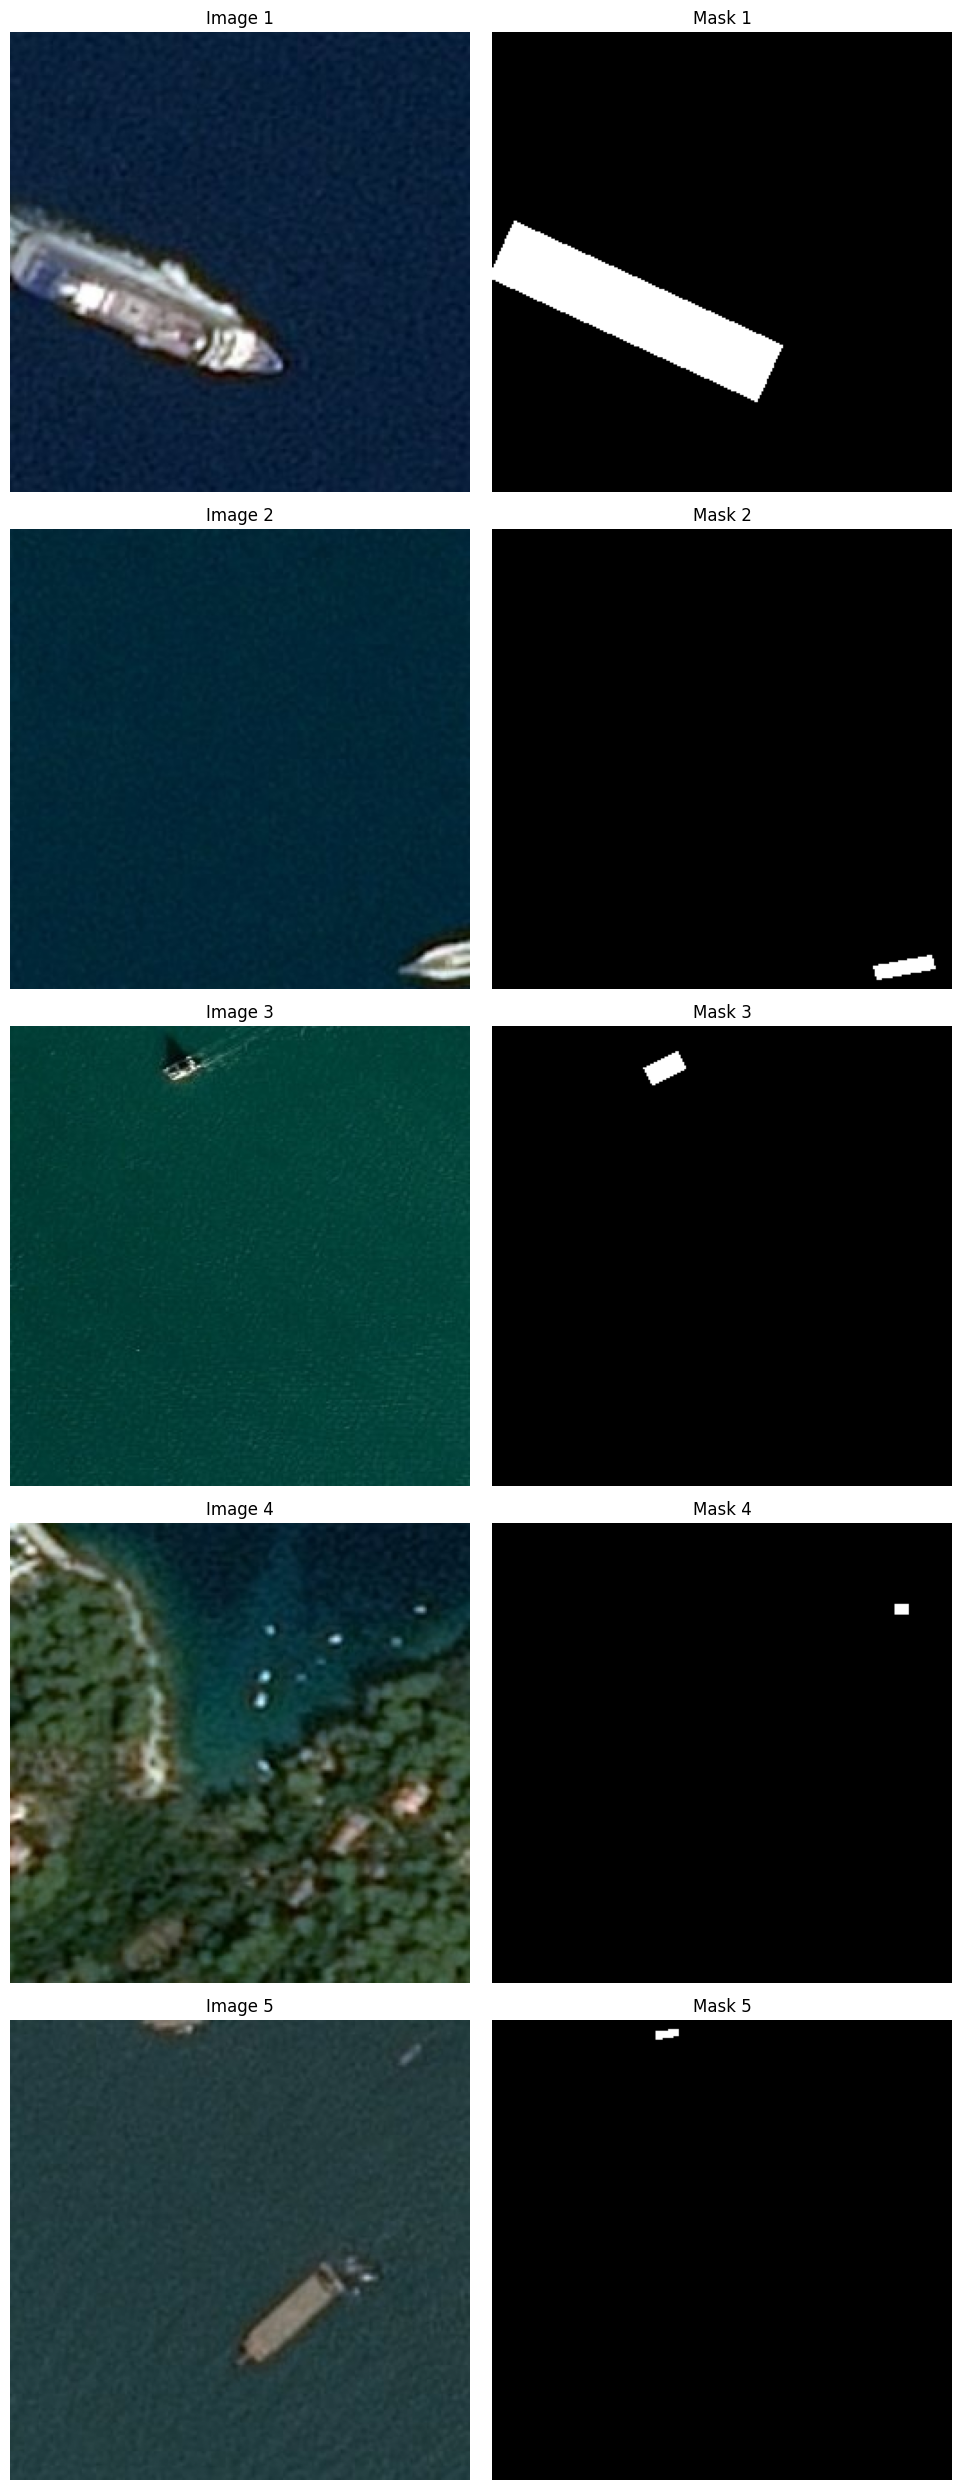

In [52]:
train.show_samples(5)

In [53]:
len(train), len(valid)

(800, 200)

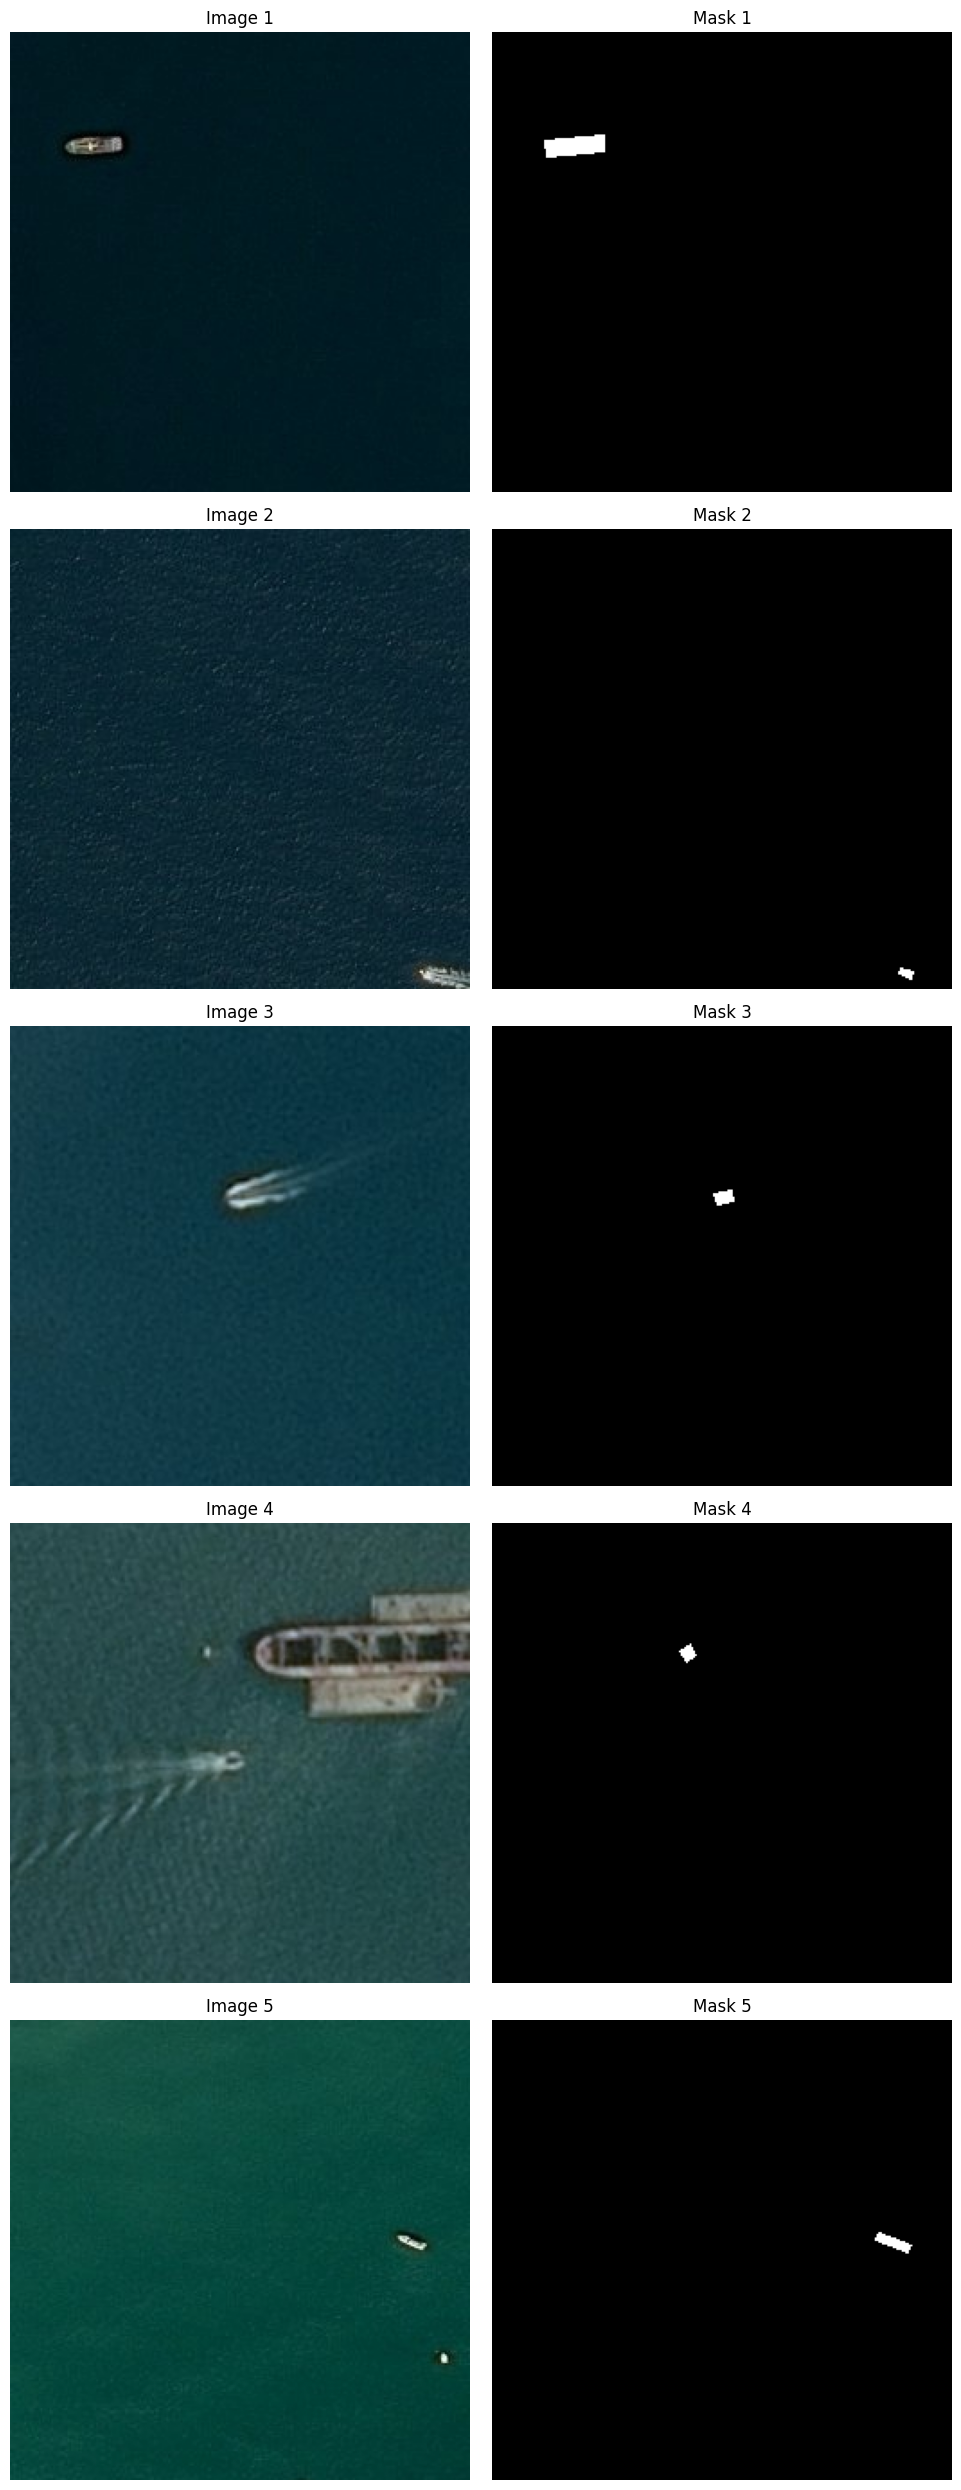

In [54]:
train.show_samples(5)

Losses

In [56]:
def BCE_dice(y_true, y_pred):
    return  K.binary_crossentropy(y_true, y_pred)+  (1-dice_score(y_true, y_pred))

In [57]:
def dice_score(y_true, y_pred):
    return (2.0*K.sum(y_pred * y_true)+0.0001) / (K.sum(y_true)+ K.sum(y_pred)+0.0001)

# Baseline model 


In [58]:
 
def encoder_block(inputs, num_filters): 
  
    # Convolution with 3x3 filter followed by ReLU activation 
    x = tf.keras.layers.Conv2D(num_filters,  
                               3,  
                               padding = 'same')(inputs) 
    x = tf.keras.layers.Activation('elu')(x) 
      
    # Convolution with 3x3 filter followed by ReLU activation 
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Conv2D(num_filters,  
                               3,  
                               padding = 'same')(x) 
    x = tf.keras.layers.Activation('elu')(x) 
  
    # Max Pooling with 2x2 filter 
    x = tf.keras.layers.MaxPool2D(pool_size = (2, 2), 
                                  strides = 2)(x) 
      
    return x

In [59]:
def decoder_block(inputs, skip_features, num_filters): 
  
    # Upsampling with 2x2 filter 
    x = tf.keras.layers.Conv2DTranspose(num_filters, 
                                        (2, 2),  
                                        strides = 2,  
                                        padding = 'same')(inputs) 
      
    # Copy and crop the skip features  
    # to match the shape of the upsampled input 
    skip_features = tf.image.resize(skip_features, 
                                    size = (x.shape[1], 
                                            x.shape[2])) 
    x = tf.keras.layers.Concatenate()([x, skip_features]) 
    
    x = tf.keras.layers.Dropout(0.2)(x)

    # Convolution with 3x3 filter followed by ReLU activation 
    x = tf.keras.layers.Conv2D(num_filters, 
                               3,  
                               padding = 'same')(x) 
    x = tf.keras.layers.Activation('elu')(x) 
    
    # Convolution with 3x3 filter followed by ReLU activation 
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same')(x) 
    x = tf.keras.layers.Activation('elu')(x) 
      
    return x

In [60]:
def unet_model(input_shape = (SIZE, SIZE, 3), num_classes = 1): 
    inputs = tf.keras.layers.Input(input_shape) 
      
    # Contracting Path 
    s1 = encoder_block(inputs, 16) 
    s2 = encoder_block(s1, 32) 
    s3 = encoder_block(s2, 64) 
    s4 = encoder_block(s3, 128) 
      
    # Bottleneck 
    b1 = tf.keras.layers.Conv2D(128, 3, padding = 'same')(s4) 
    b1 = tf.keras.layers.Activation('elu')(b1) 
    b1 = tf.keras.layers.Dropout(0.2)(b1)
    b1 = tf.keras.layers.Conv2D(128, 3, padding = 'same')(b1) 
    b1 = tf.keras.layers.Activation('elu')(b1) 
      
    # Expansive Path 
    s5 = decoder_block(b1, s4, 128) 
    s6 = decoder_block(s5, s3, 64) 
    s7 = decoder_block(s6, s2, 32) 
    s8 = decoder_block(s7, s1, 16) 
      
    # Output 
    outputs = tf.keras.layers.Conv2D(num_classes,  
                                     1,  
                                     padding = 'same',  
                                     activation = 'sigmoid')(s8) 
      
    model = tf.keras.models.Model(inputs = inputs,  
                                  outputs = outputs,  
                                  name = 'U-Net') 
    return model 

In [61]:
model = unet_model(num_classes=1) 
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['activation[0][0]']          
                                                                                              

In [62]:
model.compile(optimizer='adam', loss=BCE_dice, metrics=[dice_score])

In [63]:
model_dir = '/kaggle/working/models'

In [64]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

if not os.path.isdir(model_dir):
    os.mkdir(model_dir)
    
weight_path="{}_weights.best.hdf5".format(model_dir)

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.33, 
                                   patience=1, 
                                   verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=1e-8)
early = EarlyStopping(monitor="val_loss", 
                      mode="min",
                      verbose = 2,
                      patience=10) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [65]:
loss_history = model.fit(train,
                             epochs=10, 
                             validation_data=valid,
                             callbacks=callbacks_list,
                             batch_size=16
                                       )

Epoch 1/10
 31/800 [>.............................] - ETA: 1:24:37 - loss: 1.1103 - dice_score: 0.0201

KeyboardInterrupt: 

In [ ]:
model.load_weights('/kaggle/input/saved-model/models_weights.best (1).hdf5')

In [ ]:
pred_y = model.predict(valid)
print(pred_y.shape, pred_y.min(), pred_y.max(), pred_y.mean())

In [ ]:
test_paths = os.listdir(test_dir_path)
print(len(test_paths), 'test images found')

In [ ]:
IMG_SCALING = (3,3)

In [ ]:
from skimage.io import imread

In [ ]:
def predict(img_name):
    c_path = os.path.join(test_dir_path, img_name)
    c_img = imread(c_path)
    img = np.expand_dims(c_img, 0)/255.0
#     img = crop
    if IMG_SCALING is not None:
        img = img[:, ::IMG_SCALING[0], ::IMG_SCALING[1]]
    return img, model.predict(img, verbose=0) 

In [ ]:
fig, m_axs = plt.subplots(20, 2, figsize = (10, 40))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2), c_img_name in zip(m_axs, test_paths):
    img, pred = predict(c_img_name)
    ax1.imshow(img[0])
    ax1.set_title('Image')
    ax2.imshow(pred[0, :, :, 0], vmin = 0, vmax = 1)
    ax2.set_title('Prediction')
fig.savefig('test_predictions.png')

In [ ]:
from scipy import ndimage

def split_mask(mask):
    threshold = 0.6
    threshold_obj = 8 #ignor predictions composed of "threshold_obj" pixels or less
    labeled,n_objs = ndimage.label(mask > threshold)
    result = []
    for i in range(n_objs):
        obj = (labeled == i + 1).astype(int)
        if(obj.sum() > threshold_obj): result.append(obj)
    return result

In [ ]:
def rle_encode(img):
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


In [ ]:
def get_run_length_encoded_predictions(y_pred, img_name):
    list_dict = []
    masks = split_mask(y_pred)
    if len(masks) == 0:
        list_dict.append({"ImageId": img_name, "EncodedPixels": np.nan})
    for mask in masks:
        list_dict.append({"ImageId": img_name, "EncodedPixels": rle_encode(mask)})
    return list_dict

In [ ]:
def predict_and_decode(test_img_names):
    list_dict = []
    for img_name in test_img_names:
        _ , pred = predict(img_name)
        rle_pred = get_run_length_encoded_predictions(pred[0], img_name)
        list_dict += rle_pred
    return pd.DataFrame(list_dict, columns=["ImageId", "EncodedPixels"])    

In [ ]:
test_decoded_pred_df = predict_and_decode(test_paths)
test_decoded_pred_df.to_csv('submission.csv', index=False)
test_decoded_pred_df

In [ ]:
import warnings

# Disable displaying warnings
warnings.filterwarnings('ignore')

In [ ]:
# with zipfile.ZipFile('prep_images.zip', 'w') as zip:
#     for id in df.ImageId:
#         img_path = os.path.join(train_dir_path, id)
#         img = Image.open(img_path)
#             # Add the image file to the Zip file
#         zip.write(img_path, os.path.basename(img_path))